In [11]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [12]:
data = pd.read_json("/tmp/log/data.json", lines=True)
data["rnd"] = np.random.random(len(data))

data.head(20)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2023-04-11 11:33:34.189,3255,2659,1.00,0.014195,5125.0,{'RECOMMENDERS': 'T2'},0.374540
1,next,2023-04-11 11:33:34.198,3255,5125,0.74,0.000113,789.0,{'RECOMMENDERS': 'T2'},0.950714
2,next,2023-04-11 11:33:34.199,3255,789,1.00,0.000088,740.0,{'RECOMMENDERS': 'T2'},0.731994
3,next,2023-04-11 11:33:34.200,3255,740,0.07,0.000088,20379.0,{'RECOMMENDERS': 'T2'},0.598658
4,next,2023-04-11 11:33:34.201,3255,20379,0.12,0.000083,5538.0,{'RECOMMENDERS': 'T2'},0.156019
5,next,2023-04-11 11:33:34.203,3255,5538,0.34,0.000086,1829.0,{'RECOMMENDERS': 'T2'},0.155995
6,next,2023-04-11 11:33:34.204,3255,1829,0.08,0.000082,3399.0,{'RECOMMENDERS': 'T2'},0.058084
7,next,2023-04-11 11:33:34.205,3255,3399,0.27,0.000085,4186.0,{'RECOMMENDERS': 'T2'},0.866176
8,next,2023-04-11 11:33:34.206,3255,4186,1.00,0.000081,3399.0,{'RECOMMENDERS': 'T2'},0.601115
9,last,2023-04-11 11:33:34.207,3255,3399,0.00,0.000052,NaN,{'RECOMMENDERS': 'T2'},0.708073


## Compute track popularity

In [13]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,177,148.53
1,2254,141.40
2,176,138.69
3,171,133.83
4,156,127.36


In [14]:
len(track_popularity)

19460

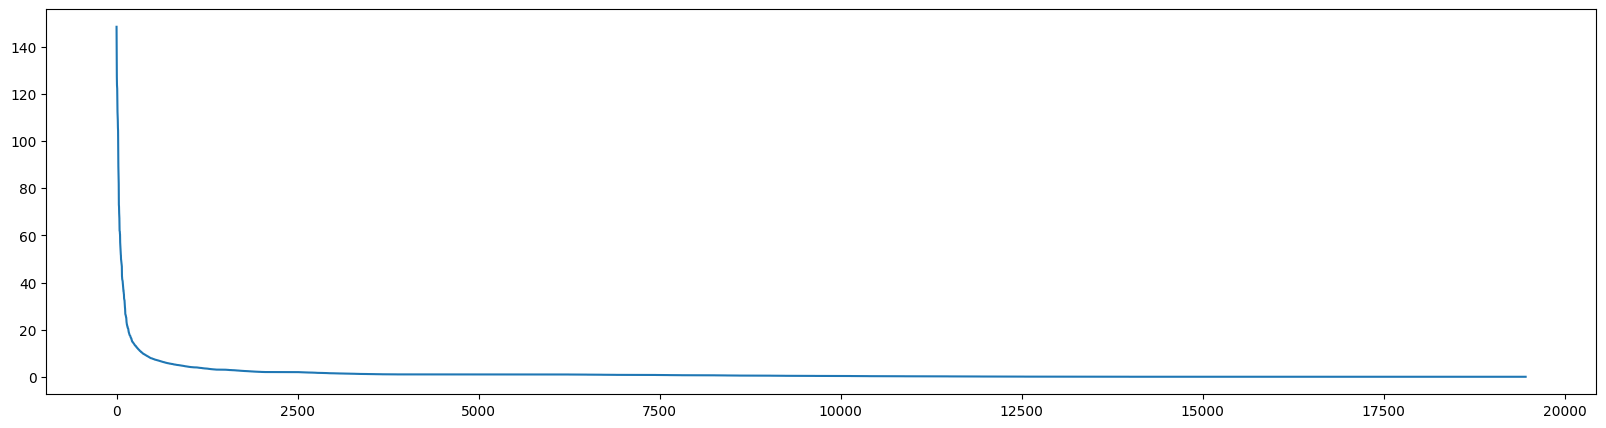

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

# ax.set_xscale("log")
# ax.set_yscale("log")

pass

## Compute offline metrics

In [16]:
# recommendations - список рекомендованных track id от лучшего к худшему
# track           - id трека, который выбрал пользователь
# k               - k в precision@K


def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [17]:
tracks = track_popularity["track"].tolist()

t_p_10 = lambda track: precision_at(tracks, track, 10)
st_10_p_10 = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10 = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10 = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_PrecAt10"] = metrics["track"].map(t_p_10)
metrics["shuffledTop10_PrecAt10"] = metrics["track"].map(st_10_p_10)
metrics["shuffledTop100_PrecAt10"] = metrics["track"].map(st_100_p_10)
metrics["shuffledTop1000_PrecAt10"] = metrics["track"].map(st_1000_p_10)

metrics[["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe()

,top10_PrecAt10,shuffledTop10_PrecAt10,shuffledTop100_PrecAt10,shuffledTop1000_PrecAt10
count,21836.000000,21836.000000,21836.000000,21836.000000
mean,0.005312,0.005312,0.002835,0.000531
std,0.022428,0.022428,0.016597,0.007269
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


In [18]:
def mrr(recommendations, track):
    return 1.0 / (1 + recommendations.index(track)) if track in recommendations else 0.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [19]:
tracks = track_popularity["track"].tolist()

t_mrr = lambda track: mrr(tracks, track)
st_10_mrr = lambda track: shuffled_mrr(tracks[:10], track)
st_100_mrr = lambda track: shuffled_mrr(tracks[:100], track)
st_1000_mrr = lambda track: shuffled_mrr(tracks[:1000], track)

metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_mrr"] = metrics["track"].map(t_mrr)
metrics["shuffledTop10_mrr"] = metrics["track"].map(st_10_mrr)
metrics["shuffledTop100_mrr"] = metrics["track"].map(st_100_mrr)
metrics["shuffledTop1000_mrr"] = metrics["track"].map(st_1000_mrr)

metrics[["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe()

,top10_mrr,shuffledTop10_mrr,shuffledTop100_mrr,shuffledTop1000_mrr
count,21836.000000,21836.000000,21836.000000,21836.000000
mean,0.023925,0.014436,0.014832,0.004582
std,0.089232,0.081795,0.068132,0.032331
min,0.000000,0.000000,0.000000,0.000000
25%,0.000223,0.000000,0.000000,0.000000
50%,0.001668,0.000000,0.000000,0.001160
75%,0.012500,0.000000,0.011111,0.002283
max,1.000000,1.000000,1.000000,1.000000


## Export data for prod

In [20]:
with open("/Users/n.anokhin/Desktop/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/n.anokhin/Desktop/top_tracks.json'